In [22]:
from odes.models import SIR
from odes.integrator import integrator
from odes.neural_ODE import nUIV_NODE
import torch
# import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [23]:
# helper function to step the SIR model forward and generate a data set
def generate_SIR_data(model, num_steps):
    t = torch.zeros(num_steps)
    y = torch.zeros(3, num_steps)
    y[:, 0] = torch.from_numpy(model.x)
    t[0] = torch.tensor(0.0)
    for i in range(num_steps):
        y[:, i] = torch.from_numpy(model.step())
        t[i] = torch.tensor(model.t)
    return y, t


def lp_norm_loss(y, yhat, p=2):
    return torch.norm(y-yhat, p=p)

In [24]:
# setting up SIR reference data
num_hosts = 2
num_steps = 5
dt = 0.05
torch.manual_seed(666)

time_scale = 25.0  # can make time "move faster" by scaling these constants beyond [0, 1]
beta = time_scale*0.9  # infection rate
gamma = time_scale*0.01  # recovery rate
SIR_ODE = SIR(num_hosts, beta, gamma)
SIR_x0 = np.array([0.75, 0.25, 0.0])


# generate data
SIR_stepper = integrator(SIR_ODE, SIR_x0, dt)
SIR_train_data, time_train_data = generate_SIR_data(SIR_stepper, num_steps)

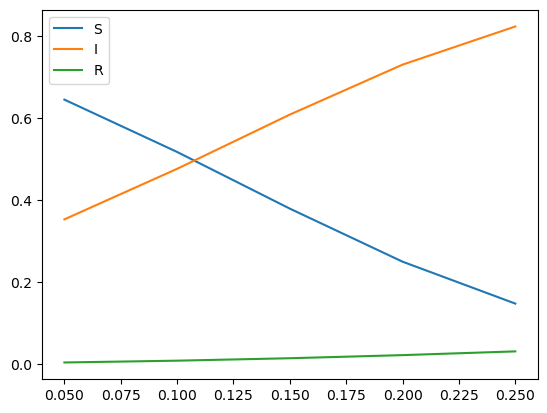

In [25]:
plt.plot(time_train_data, SIR_train_data.T)
plt.legend(["S","I","R"])
plt.show()

In [26]:
# build model and fit it
method = 'euler'
step_size = 2*dt
# build model and fit it
device = 'cpu'  # torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nUIV_NODE(num_hosts, method=method, step_size=step_size).to(device)
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)
loss_function = lambda y, yhat: lp_norm_loss(y, yhat, p=2)  # nn.L1Loss()

In [27]:
train_beta = torch.tensor([1.35e-7,1.26e-7,5.24e-7,7.92e-10,1.51e-7,5.74e-10,1.23e-7,2.62e-9,3.08e-10])
log_train_beta = torch.log10(train_beta)
train_delta = torch.tensor([0.61,0.81,0.51,1.21,2.01,0.81,0.91,1.61,2.01])
#train_p = torch.tensor([0.2,0.2,0.2,361.6,0.2,382,0.2,278.2,299])
#log_train_p = torch.log10(train_p)
train_p = torch.tensor([0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2])
train_c = 2.4*torch.ones(9)

#train_params = torch.tensor([torch.mean(log_train_beta),torch.mean(train_delta),torch.mean(log_train_p),torch.mean(train_c)])
train_params = torch.cat((torch.mean(log_train_beta)*torch.ones(num_hosts),torch.mean(train_delta)*torch.ones(num_hosts),torch.mean(train_p)*torch.ones(num_hosts),torch.mean(train_c)*torch.ones(num_hosts)))

com_train = torch.cat((SIR_train_data[1,:],0.01*train_params,torch.zeros(num_hosts)))

In [28]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    SIR_est = model.simulate(time_train_data.to(device)).to(device)
    # print(SIR_est)
    UIV_x0_est = model.nUIV_x0
    #UIV_x0_est = UIV_x0_est.T
    #UIV_U0_est = UIV_x0_est[::3]
    #UIV_I0_est = UIV_x0_est[1::3]
    #UIV_V0_est = UIV_x0_est[2::3]
    #com_est = torch.cat((SIR_est[1,:],1/5*torch.log10(UIV_U0_est),1/5*UIV_I0_est,1/5*torch.log10(UIV_V0_est)),dim=0)

    beta_est = model.nUIV_dynamics.betas
    log_beta_est = torch.log10(beta_est)
    delta_est = model.nUIV_dynamics.deltas
    p_est = model.nUIV_dynamics.ps
    log_p_est = torch.log10(p_est)
    c_est = model.nUIV_dynamics.cs

    #params_est = torch.tensor([torch.mean(log_beta_est),torch.mean(delta_est),torch.mean(log_p_est),torch.mean(c_est)])
    params_est = torch.cat((log_beta_est,delta_est,p_est,c_est))
    
    # print("UIV est", UIV_x0_est[3::3])
    com_est = torch.cat((SIR_est[1,:],0.01*params_est,UIV_x0_est[3::3]))
    # print(SIR_est[1,:])
    print(UIV_x0_est[3::3])
    print(UIV_x0_est[3::3].shape)

    print(torch.zeros(num_hosts))
    print(torch.zeros(num_hosts).shape)

    loss = loss_function(com_est, com_train.to(device))
    #loss = loss_function(SIR_est, SIR_train_data.to(device))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')
    break

tensor([ 3.5438e-01,  3.5717e-01,  3.5998e-01,  3.6226e-01,  3.6456e-01,
        -9.5861e-03, -2.1451e-02,  3.2860e-03,  6.2411e-07,  7.7168e-03,
         2.7893e-03,  6.3514e-04,  3.0445e-03,  1.0240e-02],
       grad_fn=<CatBackward0>)
torch.Size([14])
tensor([ 0.3523,  0.4757,  0.6080,  0.7299,  0.8230, -0.0780, -0.0780,  0.0117,
         0.0117,  0.0020,  0.0020,  0.0240,  0.0240,  0.0000,  0.0000])
torch.Size([15])


RuntimeError: The size of tensor a (14) must match the size of tensor b (15) at non-singleton dimension 0

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}, Gradient: {param.grad}")


nUIV_params = model.get_params()
SIR_params = {'beta': beta,
              'gamma': gamma,
              'x0': SIR_x0,
              'num_hosts': num_hosts}

sim_params = {'SIR': SIR_params,
              'nUIV': nUIV_params}

print(nUIV_params)

Parameter name: nUIV_dynamics.parametrizations.betas.original, Gradient: tensor([0.0009, 0.0330])
Parameter name: nUIV_dynamics.parametrizations.deltas.original, Gradient: tensor([-2.2254e-05, -7.7624e-05])
Parameter name: nUIV_dynamics.parametrizations.cs.original, Gradient: tensor([0.0013, 0.0140])
Parameter name: nUIV_dynamics.parametrizations.ps.original, Gradient: tensor([-5.2518e-03,  4.0502e-05])
Parameter name: nUIV_dynamics.parametrizations.ts.original, Gradient: tensor([[ 0.0023, -0.0008],
        [-0.0005,  0.0369]])
Parameter name: nUIV_to_SIR.slope, Gradient: tensor([0.0354])
Parameter name: nUIV_to_SIR.threshold, Gradient: tensor([1.8385])
Parameter name: nUIV_to_SIR.W.weight, Gradient: None
Parameter name: parametrizations.nUIV_x0.original, Gradient: tensor([-1.6743e-06, -9.6494e-03, -1.0381e-01,  1.7273e-03, -1.1308e-08,
        -4.5153e-03, -6.0954e-01,  1.0101e-03])
{'beta': array([0.22395402, 0.00848239], dtype=float32), 'delta': array([0.12388617, 0.42478874], dtype